<div style="text-align:center;">
    <img src="img/PPGE3M_UFRGS_logo.png" alt="Logo PPGE3M-UFRGS" width="450px">
</div>

# DETECÇÃO DE DESCRIÇÕES LITOLÓGICAS ANÔMALAS UTILIZANDO ISOLATION FOREST: UM ESTUDO DE CASO EM MINA DE FOSFATO

**Notebook complementar ao artigo do CBMina 2025**

Autores: [Franco Naghetini](www.linkedin.com/in/fnaghetini); [Diego Marques](https://www.linkedin.com/in/diego-machado-marques-7336852b/); [Fernanda Niquini](https://www.linkedin.com/in/fernanda-gontijo-fernandes-niquini-0a6a7698/)


## Introdução

O presente estudo visa aplicar o algoritmo **Isolation Forest não-supervisionado** para a **detecção de descrições litológicas incorretas em furos de  sondagem de uma mina de fosfato**. A descrição litológica desempenha um papel fundamental na definição dos domínios de estimativa dessa mina, sendo crucial para a estimativa de recursos e a tomada de decisões operacionais. A detecção automatizada de anomalias nas descrições litológicas pode contribuir significativamente para a melhoria da qualidade dos dados e da eficiência operacional, minimizando
erros humanos e garantindo a confiabilidade das informações geológicas.


## Importação das bibliotecas

In [33]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

import warnings
warnings.filterwarnings("ignore")

## Importação dos módulos

Neste trabalho, os módulos armazenam as funções auxiliares utilizadas ao longo do fluxo de trabalho e podem ser encontrados na pasta [src](https://github.com/fnaghetini/anomaly-detection-in-drillholes/tree/main/src) do repositório. A separação do código-fonte em módulos visa garantir a legibilidade e facilitar a sua manutenção.

Os módulos presentes nesse repositório são:

- [file_io](https://github.com/fnaghetini/anomaly-detection-in-drillholes/blob/main/src/file_io.py): importação e exportação de arquivos (_file in/out_).
- [stats](https://github.com/fnaghetini/anomaly-detection-in-drillholes/blob/main/src/stats.py): cálculo de estatísticas.
- [plot](https://github.com/fnaghetini/anomaly-detection-in-drillholes/blob/main/src/plot.py): plotagem de gráficos e mapas.
- [pdp_tool](https://github.com/fnaghetini/anomaly-detection-in-drillholes/blob/main/src/stats.py): cálculo do _partial dependent plot_ (créditos: [pdp-tool](https://github.com/attilalr/pdp-tool)).
- [preprocessing](https://github.com/fnaghetini/anomaly-detection-in-drillholes/blob/main/src/preprocessing.py): procedimentos de pré-processamento.
- [postprocessing](https://github.com/fnaghetini/anomaly-detection-in-drillholes/blob/main/src/postprocessing.py): procedimentos de pós-processamento.

In [34]:
import src.file_io as io
import src.stats as stats
import src.plot as plot
import src.pdp_tool as pdp
import src.preprocessing as pre
import src.postprocessing as post

## Base de dados

A base de dados deste trabalho contempla um subconjunto de furos de sondagem de uma mina real de fosfato. Cada linha representa um intervalo amostral de um determinado furo.

As colunas são representadas por:
- `BHID`: identificador do furo de sondagem
- `FROM`: início do intervalo amostral (em metros)
- `TO`: final do intervalo amostral (em metros)
- `X`: coordenada X do centroide do intervalo amostral (em UTM)
- `Y`: coordenada Y do centroide do intervalo amostral (em UTM)
- `Z`: coordenada Z do centroide do intervalo amostral (em UTM)
- `LITO`: litotipo presente no intervalo amostral
- Demais colunas: resultados químicos associado ao intervalo amostral (em %)

In [35]:
# Colunas
PK = ['BHID', 'FROM', 'TO']
COORDS = ['X', 'Y', 'Z']
ANALYTES = ['P2O5', 'CAO', 'FE2O3', 'SIO2', 'AL2O3', 'MGO']
ALL_COLS = PK + COORDS + ANALYTES + ['LITO']
LITHOS = ['Bebedourito', 'Carbonatito', 'Argilito', 'Canga', 'Foscrete']

In [36]:
# Importação
dh = io.read_csv('drillholes.csv')
dh = dh[dh['LITO'].isin(LITHOS)][ALL_COLS]
dh.reset_index(drop=True, inplace=True)

In [37]:
dh.head()

,BHID,FROM,TO,X,Y,Z,P2O5,CAO,FE2O3,SIO2,AL2O3,MGO,LITO
0,DH-0001,3.40,5.00,678.2769,1906.266,408.3772,1.41,0.09,42.3,6.22,14.3,0.58,Argilito
1,DH-0001,5.00,8.65,678.1301,1906.344,405.7575,2.17,0.10,41.2,8.36,13.1,0.43,Argilito
2,DH-0001,8.65,12.00,677.9395,1906.447,402.2642,4.77,0.16,41.6,10.10,13.5,0.13,Bebedourito
3,DH-0001,12.00,15.00,677.7742,1906.552,399.0953,3.57,0.17,44.2,10.70,12.0,0.14,Bebedourito
4,DH-0001,15.00,18.00,677.6160,1906.664,396.1015,2.97,0.16,42.1,12.30,12.9,0.12,Bebedourito


## Limpeza dos dados

In [38]:
print(f"A base de dados apresenta {len(dh)} linhas e {len(dh.columns)} colunas.")

A base de dados apresenta 15526 linhas e 13 colunas.


In [39]:
stats.get_summary_table(dh)

,dType,Valores Faltantes,Valores Preenchidos,% Valores Preenchidos,Valores Únicos
BHID,object,0,15526,1.000000,536
FROM,float64,0,15526,1.000000,2905
TO,float64,0,15526,1.000000,3046
X,float64,0,15526,1.000000,8697
Y,float64,0,15526,1.000000,8609
Z,float64,0,15526,1.000000,14656
P2O5,float64,35,15491,0.997746,2168
CAO,float64,35,15491,0.997746,1261
FE2O3,float64,35,15491,0.997746,3008
SIO2,float64,35,15491,0.997746,1554


- Não existem valores faltantes da chave primária (i.e. `BHID`, `FROM` e `TO`)
- Não existem valores faltantes de coordenadas.
- Não existem valores faltantes de `LITO`.
- Existem apenas 35 intervalos com valores dos analitos químicos ausentes.

Como tratamento inicial dos valores faltantes a seguinte premissa foi assumida: caso um intervalo não apresente ao menos um analito com valor válido, ele será removido. Apenas 35 intervalos foram removidos.

In [40]:
# Isotopização da base de dados a partir dos dados químicos
dh.dropna(subset=ANALYTES, how='any', inplace=True)
dh.sort_values(by=PK, ignore_index=True, inplace=True)

In [41]:
print(f"Após a isotopização, a base de dados apresenta {len(dh)} linhas e {len(dh.columns)} colunas.")

Após a isotopização, a base de dados apresenta 15491 linhas e 13 colunas.


## Análise exploratória dos dados

### Sumário estatístico

A tabela abaixo representa o sumário estatístico geral das features (i.e. analitos).

In [42]:
stats.calculate_stats_table(dh[ANALYTES])

,X̅,50%,Min,10%,99.5%,Max,Amp,S²,S,Cᵥ,Skew
P2O5,8.574708,5.94,0.03,2.11,33.7,37.2,37.17,51.754007,7.194026,0.838982,1.518900
CAO,13.559512,13.50,0.02,0.31,49.4,53.1,53.08,164.064507,12.808767,0.944633,0.663007
FE2O3,26.592159,22.10,1.00,10.50,70.8,84.9,83.90,241.989255,15.556004,0.584985,0.785018
SIO2,19.261068,19.40,0.12,2.93,53.3,84.5,84.38,150.484375,12.267207,0.636891,0.291071
AL2O3,8.078420,3.93,0.01,0.94,34.5,40.2,40.19,88.091066,9.385684,1.161822,1.574121
MGO,3.951141,1.30,0.01,0.17,18.4,23.9,23.89,23.991341,4.898096,1.239666,1.252600


### Frequência absoluta dos litotipos

O gráfico abaixo mostra a distribuição de frequências dos litotipos (i.e. variável `LITO`).

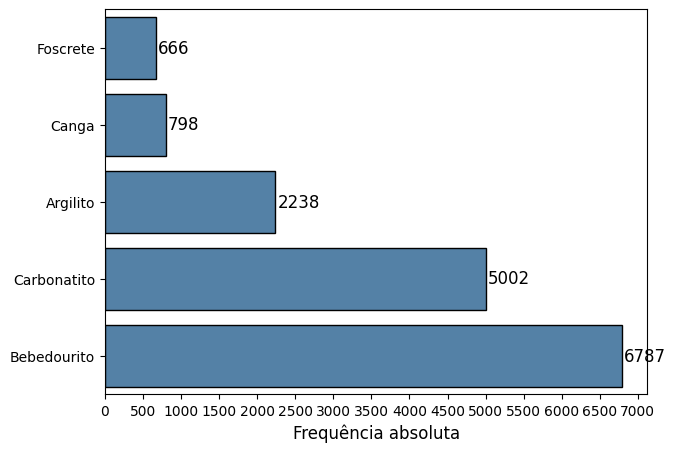

In [43]:
plot.plot_category_frequencies(dh, 'LITO')

- As litologias `Bebedourito` e `Carbonatito` representam conjuntamente mais de 75% das amostras.
- As litologias `Foscrete` e `Canga` representam conjuntamente menos de 10% das amostras.
- Portanto, nota-se um acentuado desbalanceamento de classes.

**Nota:** utilizou-se o termo "desbalanceamento de classes" apenas para ilustrar que a variável `LITO` apresenta uma distribuição desigual de suas categorias. Entretanto, enfatiza-se que a tarefa deste trabalho é do tipo **detecção de anomalias não supervisionada**, em que `LITO` será tratada como uma feature.

### Distribuição dos analitos por litotipo

O gráfico abaixo mostra a distribuição dos analitos agrupados pelos litotipos.

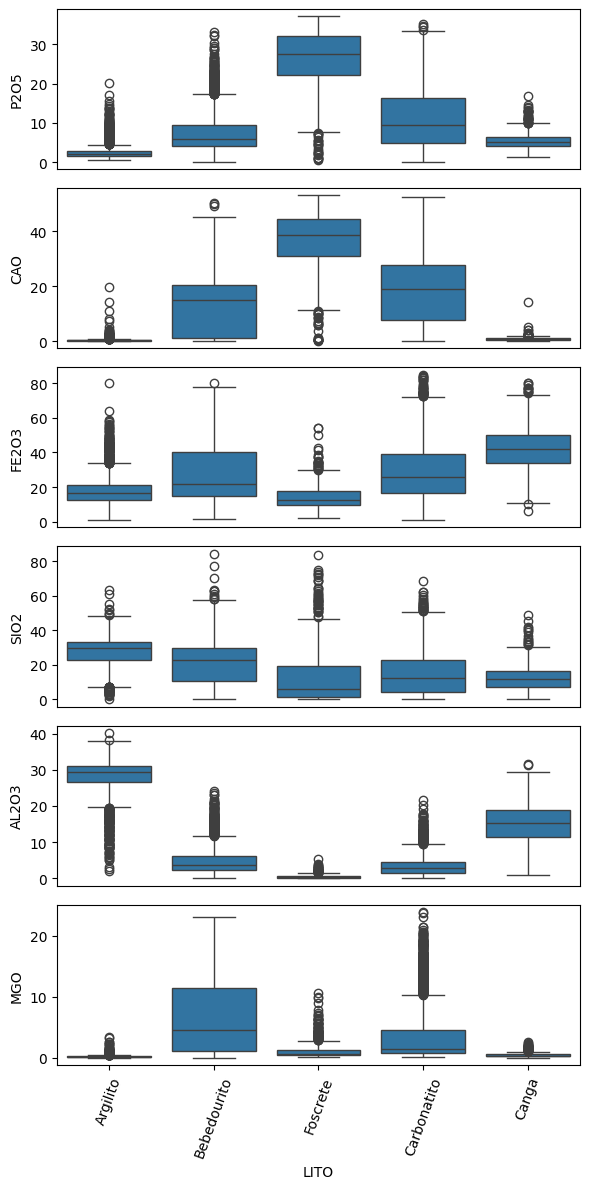

In [44]:
plot.plot_boxplots_by_litho(dh, ANALYTES, 'LITO')

- Os elementos maiores, sob a forma de óxidos (i.e. `P2O5`, `CAO`, `FE2O3`, `SIO2`, `AL2O3`, `MGO`) apresentam uma variabilidade significativa quando agrupados pelos litotipos.

### Correlação linear entre analitos

A análise da correlação entre as variáveis no espaço das features é importante para detectar a existência de features redundantes. Uma maneira se fazer isso é a partir da estatística bivariada coeficiente de correlação linear (i.e. Coeficiente de Pearson). A figura abaixo apresenta os coeficientes de correlação linear entre os analitos.

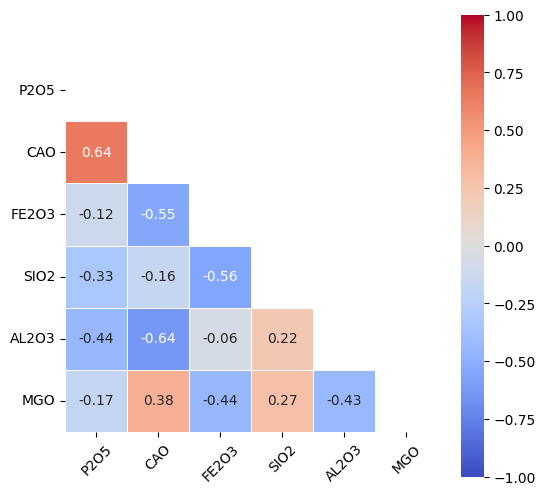

In [45]:
plot.plot_correlation_heatmap(dh, ANALYTES)

- Nenhum analito apresenta forte correlação linear entre si.
- Os analitos `P2O5` e `CAO` apresentam  correlação linear positiva significativa. Isso já era esperado, já que esses óxidos compõem a apatita.
- Os analitos `CAO` e `AL2O3` apresentam correlação linear negativa significativa.

### Partial dependent plot

O Partial Dependent Plot (PDP) é uma ferramenta de análise exploratória bastante útil para verificar a presença de correlação (não necessariamente linear) entre variáveis contínuas e categóricas.

Neste trabalho, o PDP será utilizado para verificar a correlação entre os analitos (variáveis contínuas) e os litotipos (variável categórica).

Como primeiro passo, serão criadas variáveis _dummy_ para codificar as cinco litologias presentes na base de dados.

In [46]:
pre.create_dummy_variables_from_categ_feature(dh, 'LITO')
dh.head()

,BHID,FROM,TO,X,Y,Z,P2O5,CAO,FE2O3,SIO2,AL2O3,MGO,LITO,IS_ARG,IS_BEB,IS_FOS,IS_CAR,IS_CAN
0,DH-0001,3.40,5.00,678.2769,1906.266,408.3772,1.41,0.09,42.3,6.22,14.3,0.58,Argilito,1,0,0,0,0
1,DH-0001,5.00,8.65,678.1301,1906.344,405.7575,2.17,0.10,41.2,8.36,13.1,0.43,Argilito,1,0,0,0,0
2,DH-0001,8.65,12.00,677.9395,1906.447,402.2642,4.77,0.16,41.6,10.10,13.5,0.13,Bebedourito,0,1,0,0,0
3,DH-0001,12.00,15.00,677.7742,1906.552,399.0953,3.57,0.17,44.2,10.70,12.0,0.14,Bebedourito,0,1,0,0,0
4,DH-0001,15.00,18.00,677.6160,1906.664,396.1015,2.97,0.16,42.1,12.30,12.9,0.12,Bebedourito,0,1,0,0,0


Para fins de simplificação do trabalho, serão calculados PDP's apenas para as três litologias mais frequentes (i.e. `Bebedourito`, `Carbonatito` e `Argilito`):

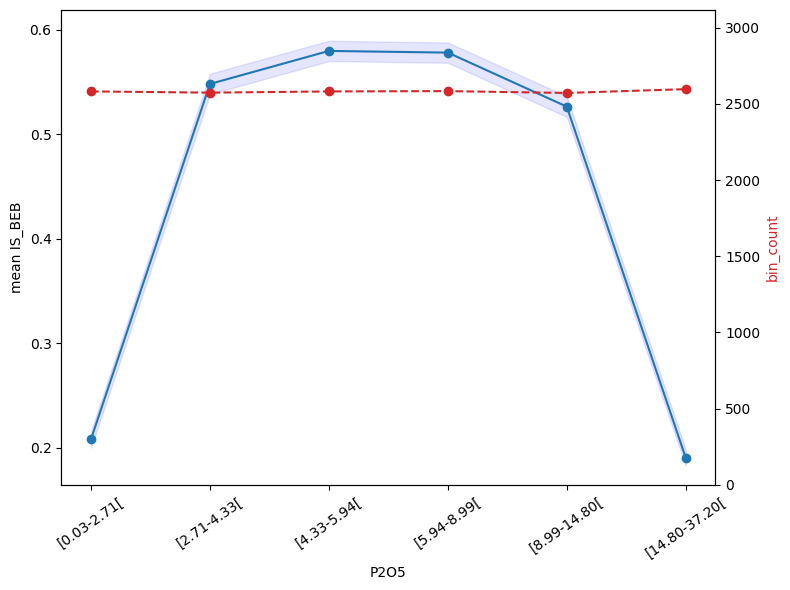

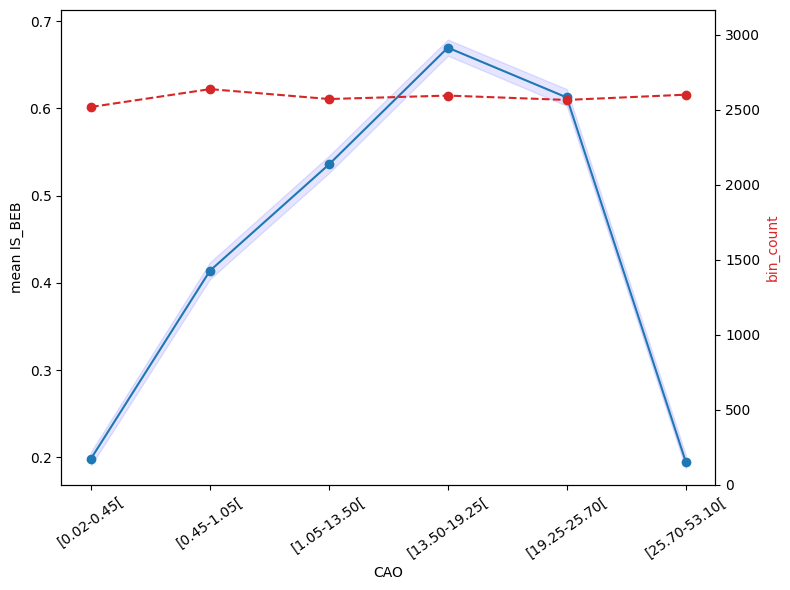

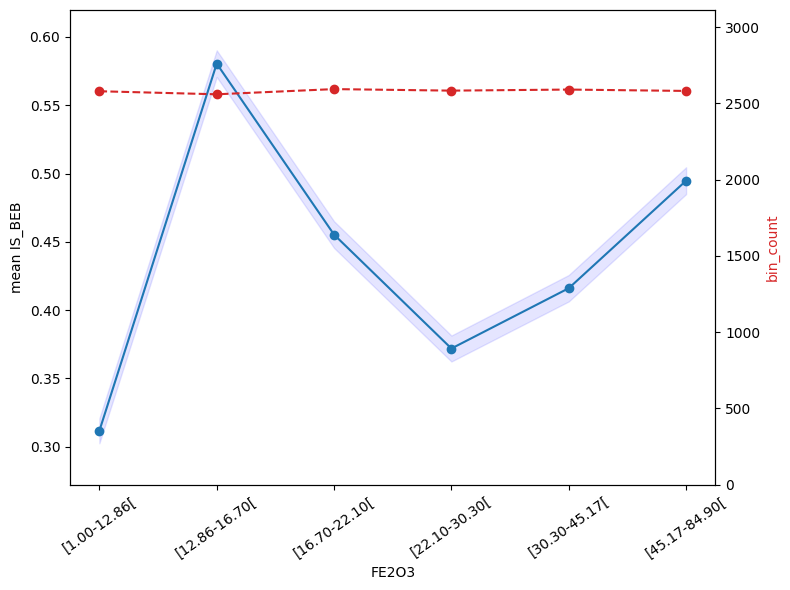

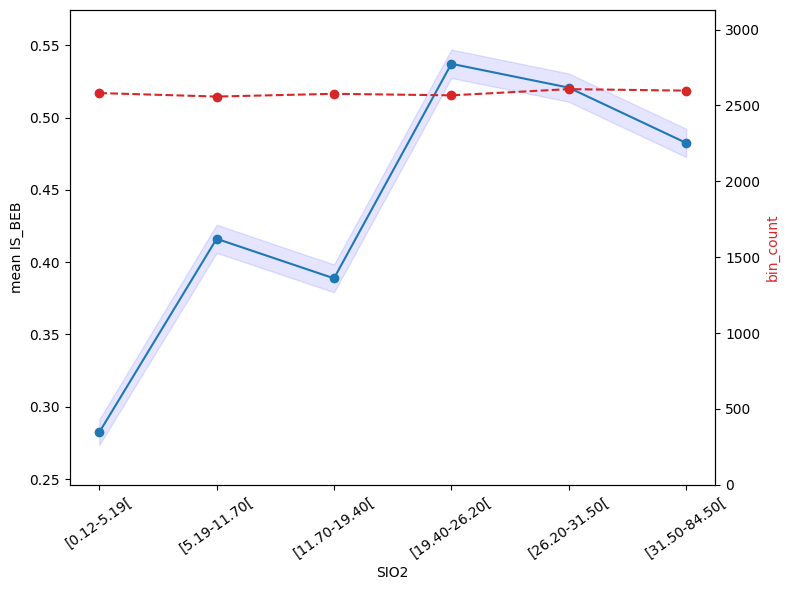

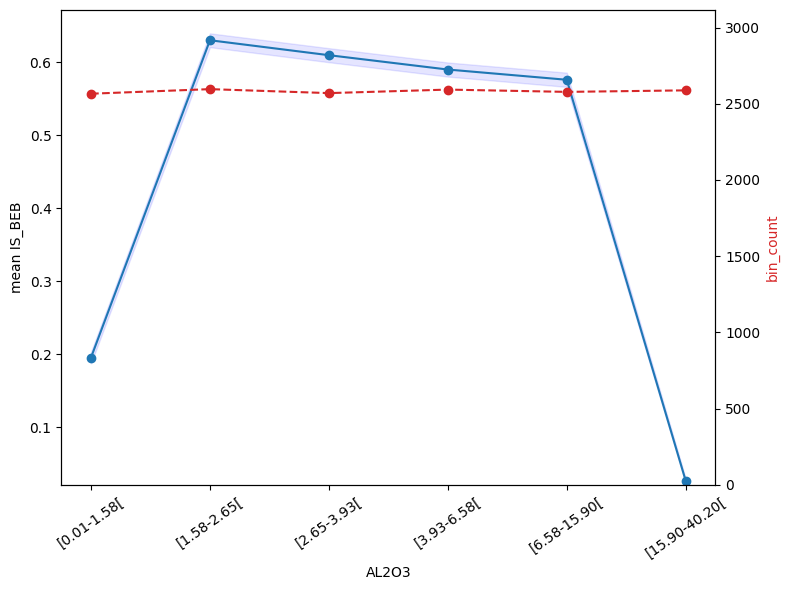

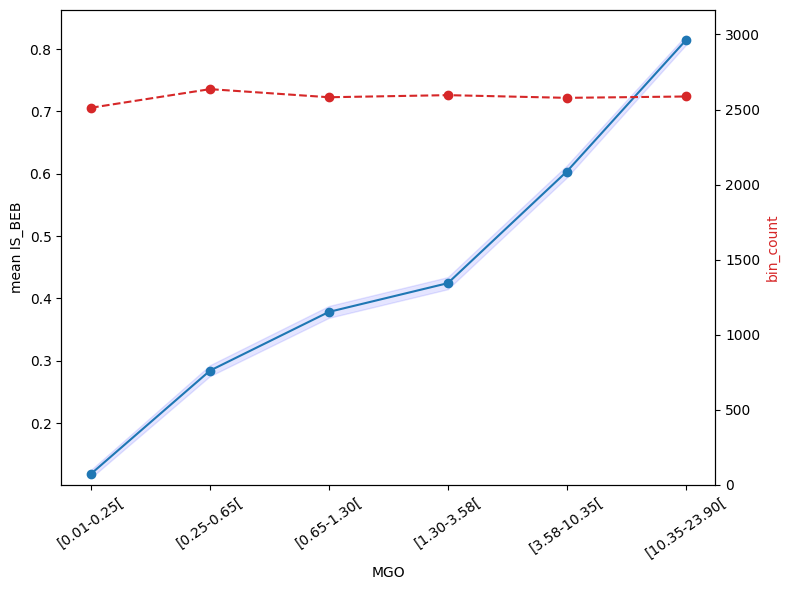

In [47]:
# PDP (Bebedourito)
pdp.pdp(dh, ANALYTES, 'IS_BEB', n=6, writefolder=None, digits=2, figsize=(8,6))

- A frequência média de `Bebedourito` tende a aumentar com o aumento dos teores de `CAO`. Isso já era esperado, pois o bebedourito é uma rocha ígnea cumulática constituída por minerais ricos em Ca (eg. diopsídio, perovskita, titanita).
- A frequência média de `Bebedourito` tende a aumentar com o aumento dos teores de `SIO2`. O aumento dos teores de sílica pode ser justificado tanto por uma contaminação crustal, quanto pela transformação da perovskita em titanita, durante a série de evolução magmática.
- A frequência média de `Bebedourito` tende a aumentar com o aumento dos teores de `MGO`. Isso pode ser justificado pelo fato de o bebedourito ser uma rocha rica em minerais máficos (i.e. ricos em magnésio), como diopsídio, flogopita e, secundariamente, olivina.

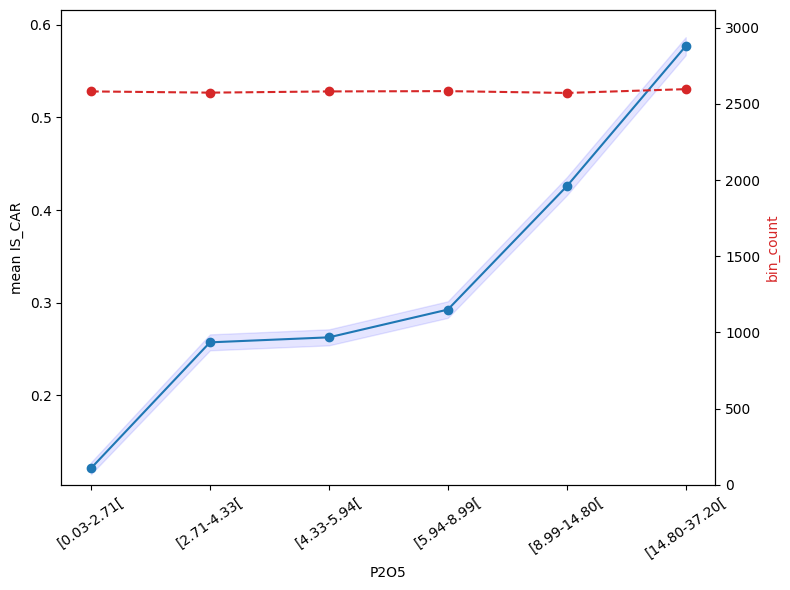

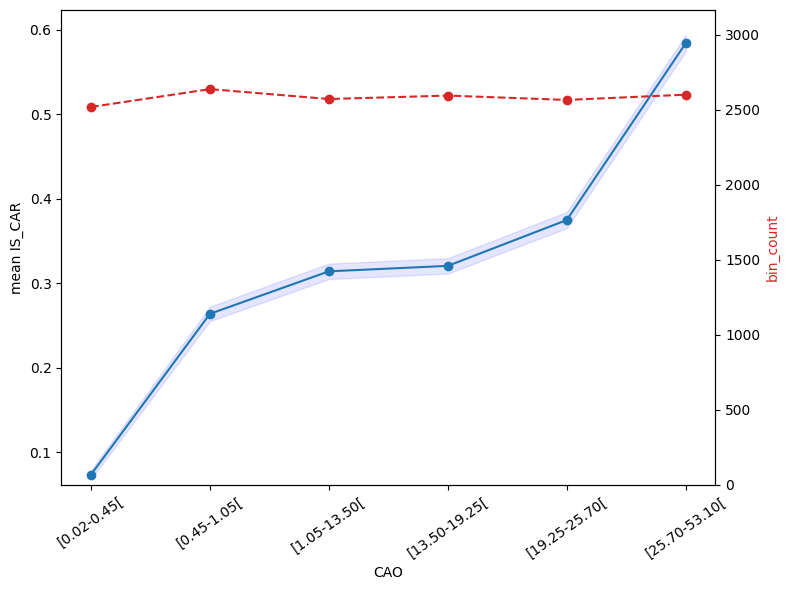

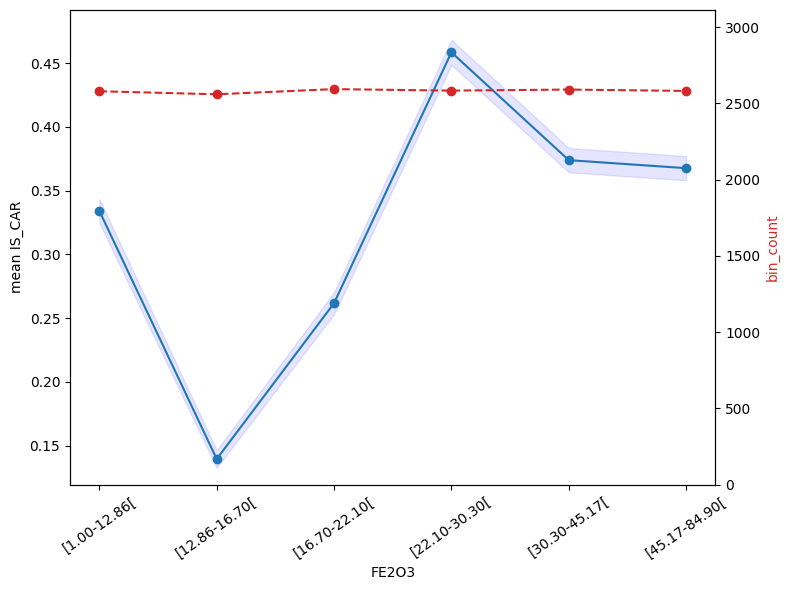

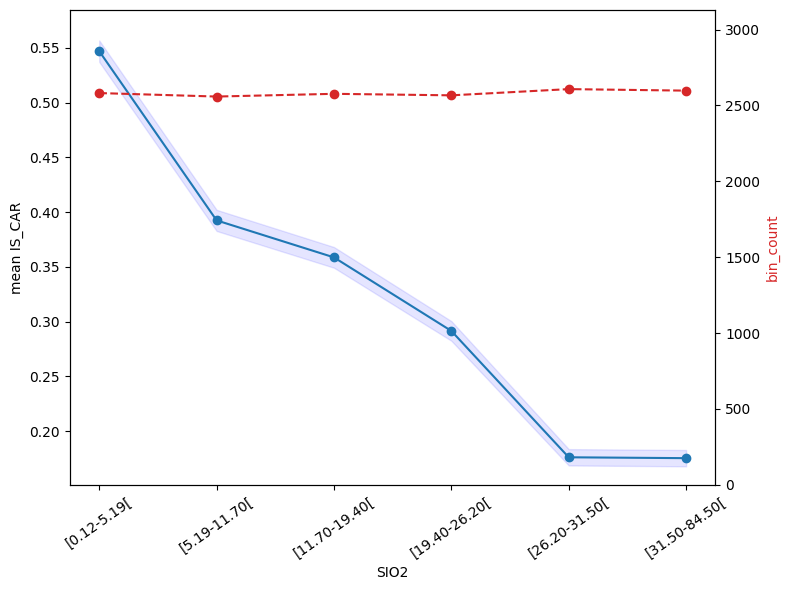

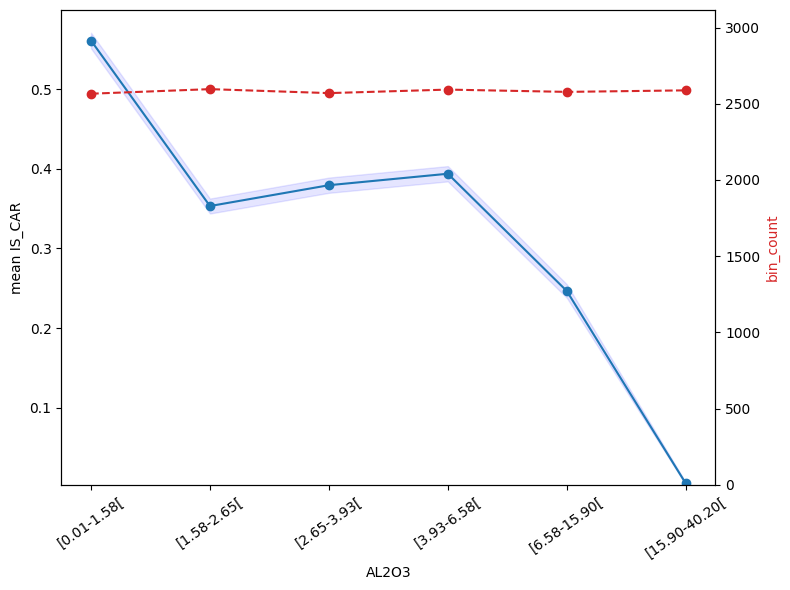

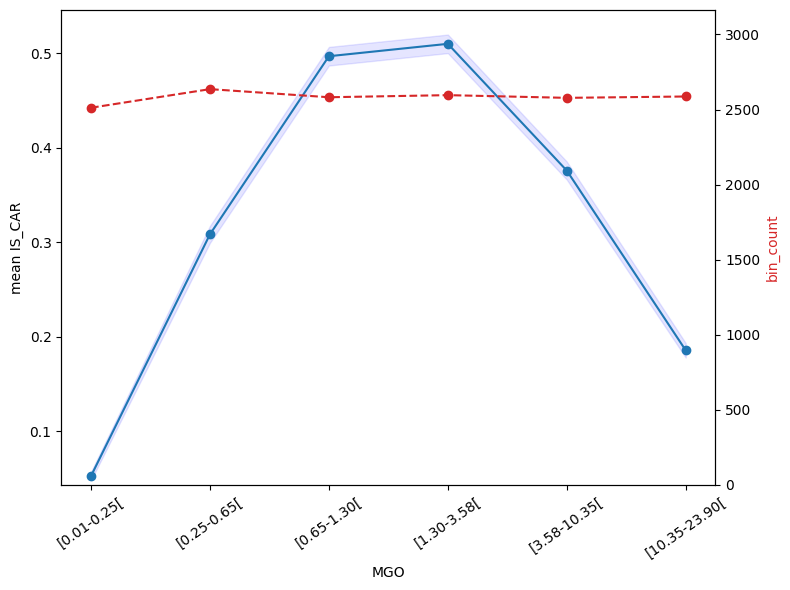

In [48]:
# PDP (Carbonatito)
pdp.pdp(dh, ANALYTES, 'IS_CAR', n=6, writefolder=None, digits=2, figsize=(8,6))

- A frequência média de `Carbonatito` tende a aumentar com o aumento dos teores de `P2O5` e `CAO`. Isso já era esperado, pois o carbonatito é uma rocha ígnea constituída por carbonatos (ricos em cálcio) e e apatita (principal fosfato de cálcio e mineral-minério).
- A frequência média de `Carbonatito` tende a diminuir com o aumento dos teores de `SIO2`. Esse comportamento era esperado, pois carbonatitos são rochas tipicamente pobres em sílica.
- A frequência média de `Carbonatito` tende a diminuir com o aumento dos teores de `AL2O3`. Esse comportamento era esperado, pois carbonatitos são rochas tipicamente pobres em alumínio.

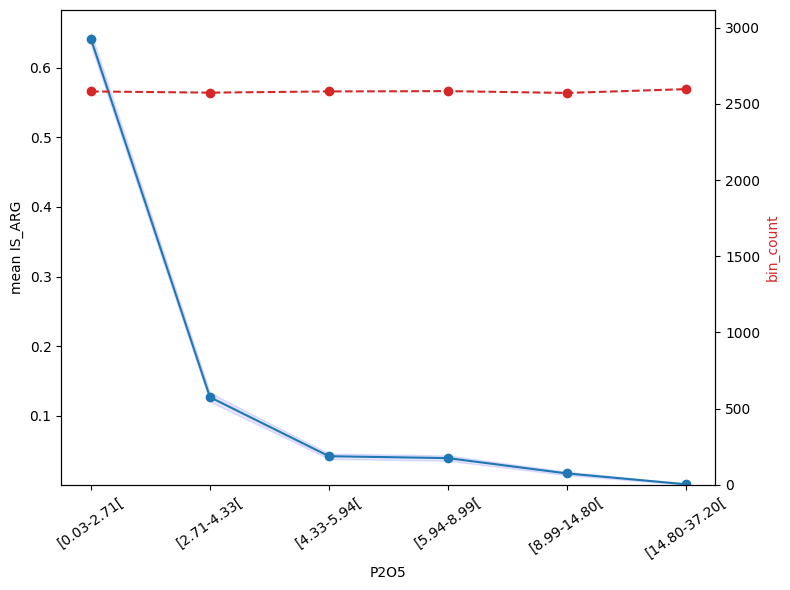

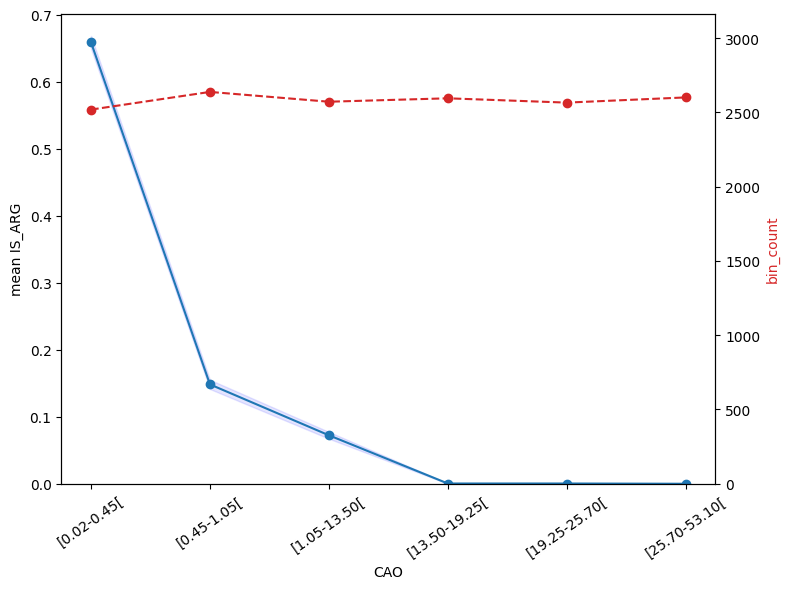

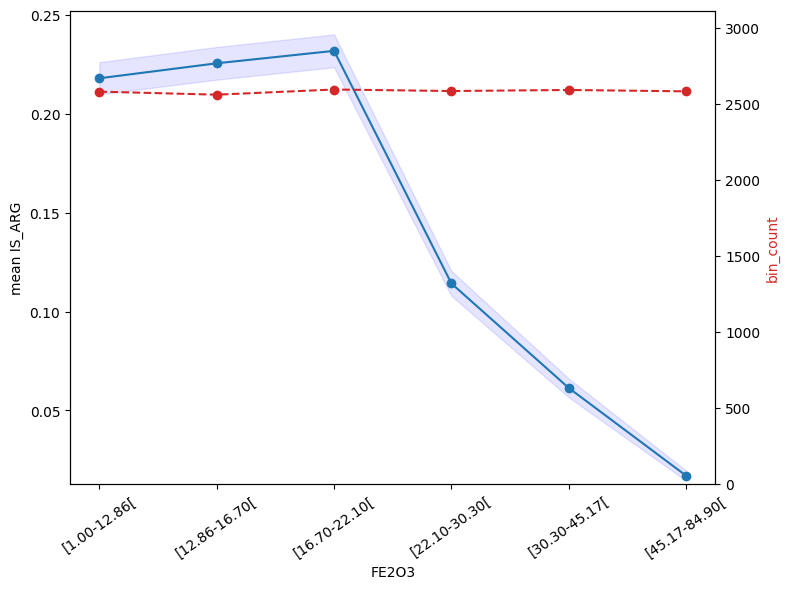

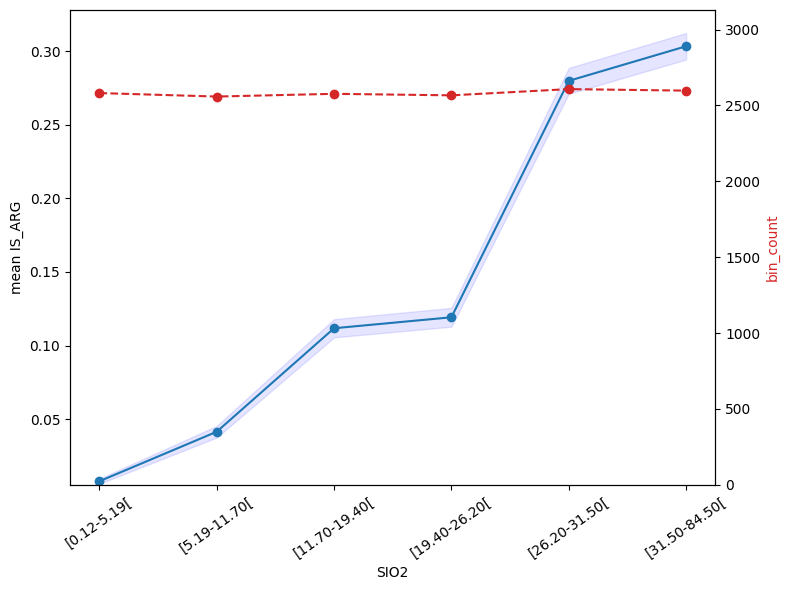

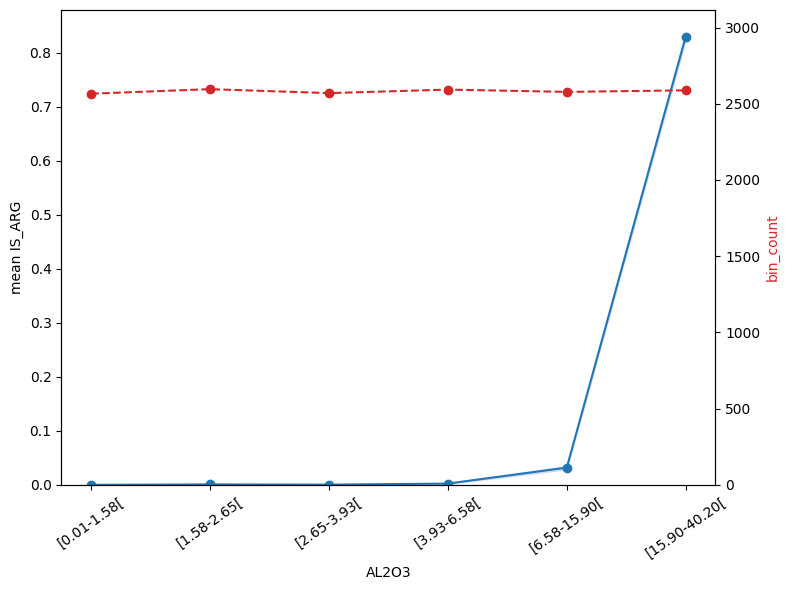

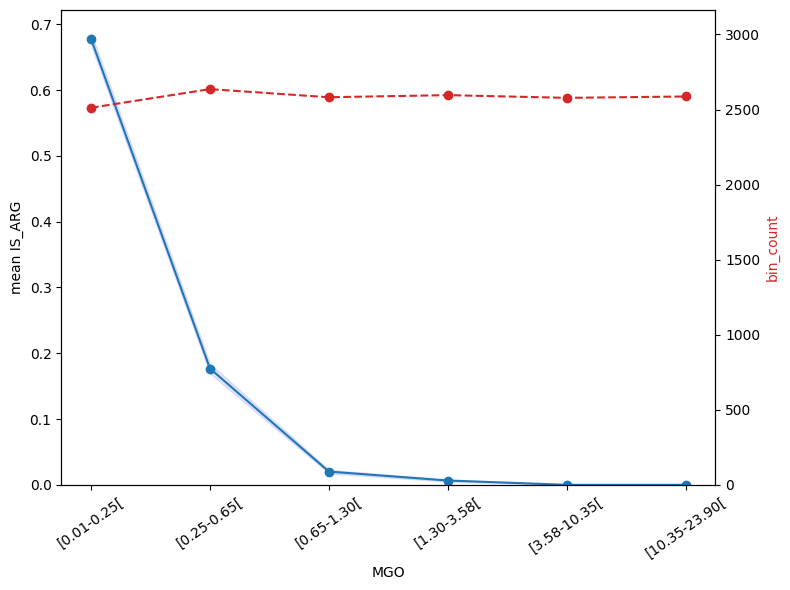

In [49]:
# PDP (Argilito)
pdp.pdp(dh, ANALYTES, 'IS_ARG', n=6, writefolder=None, digits=2, figsize=(8,6))

- A frequência média de `Argilito` tende a diminuir com o aumento dos teores de `CAO` e `MGO`. Isso já era esperado, pois o argilito é uma rocha sedimentar de granulometria argila tipicamente formada a partir do intemperismo de rochas pré-existentes. Nesse sentido, durante o intemperismo químico, elementos mais móveis (eg. Ca e Mg) tendem a ser lixiviados.
- A frequência média de `Argilito` tende a aumentar com o aumento dos teores de `SIO2` e `AL2O3`. Isso já era esperado, pois, durante o intemperismo químico, elementos mais imóveis (eg. Si e Al) tendem a se concentrar na rocha sedimentar.

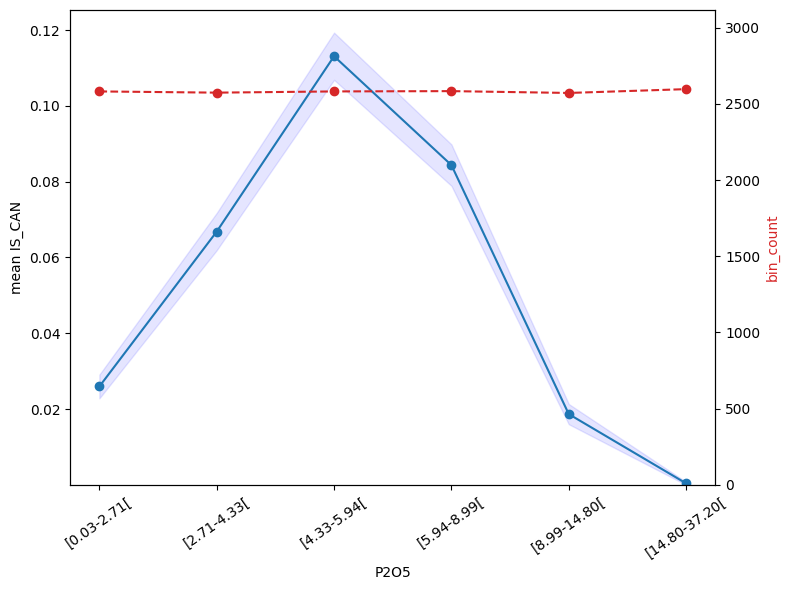

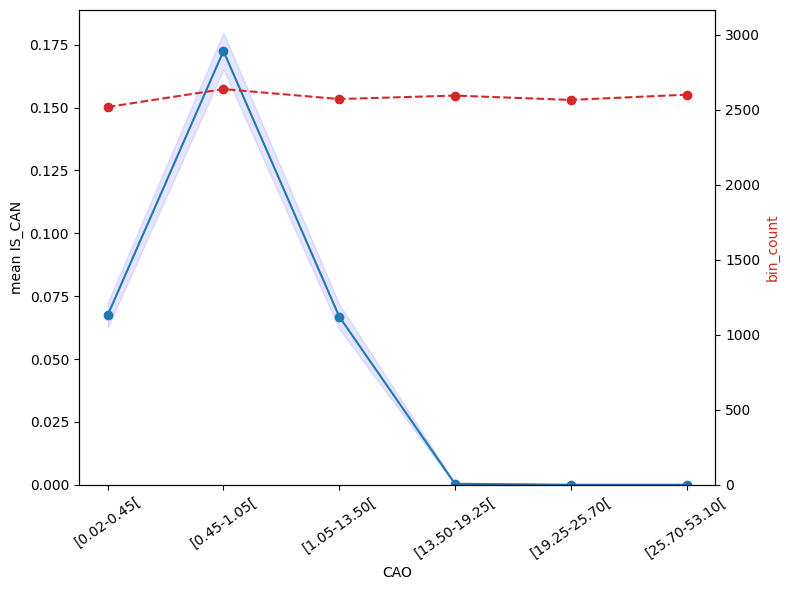

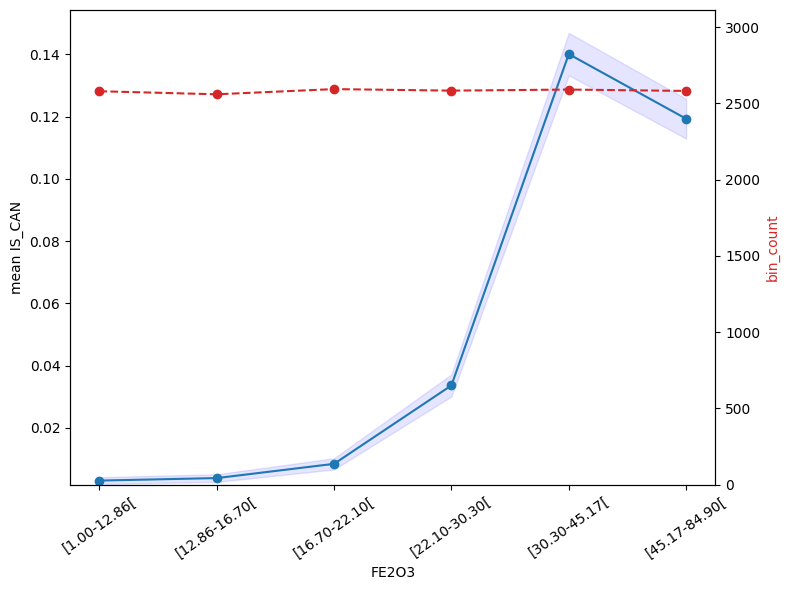

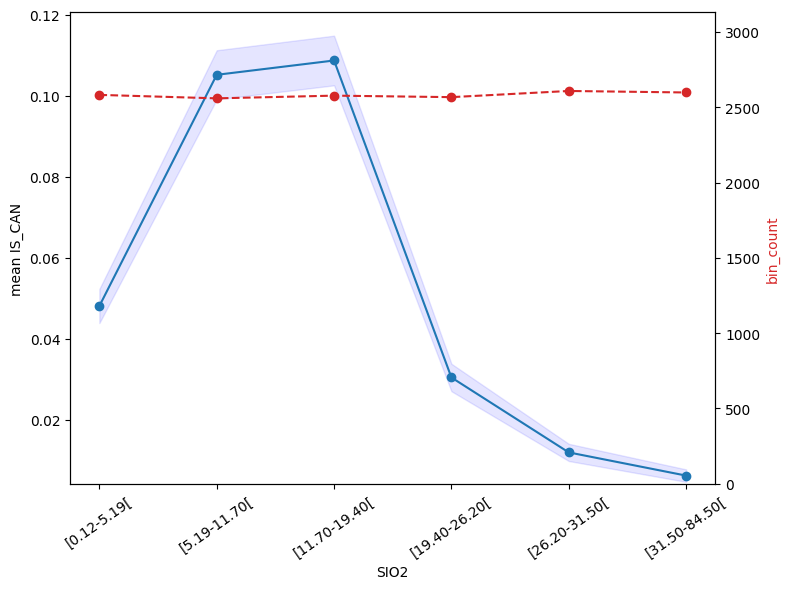

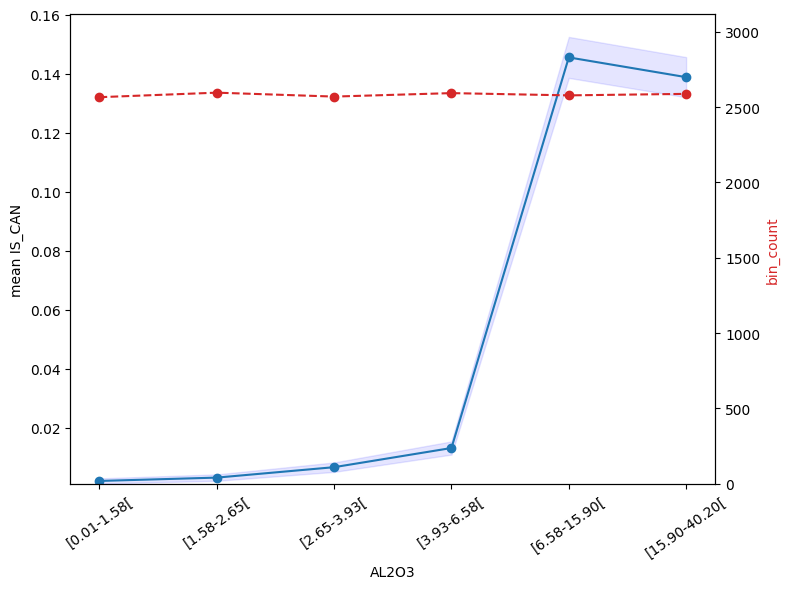

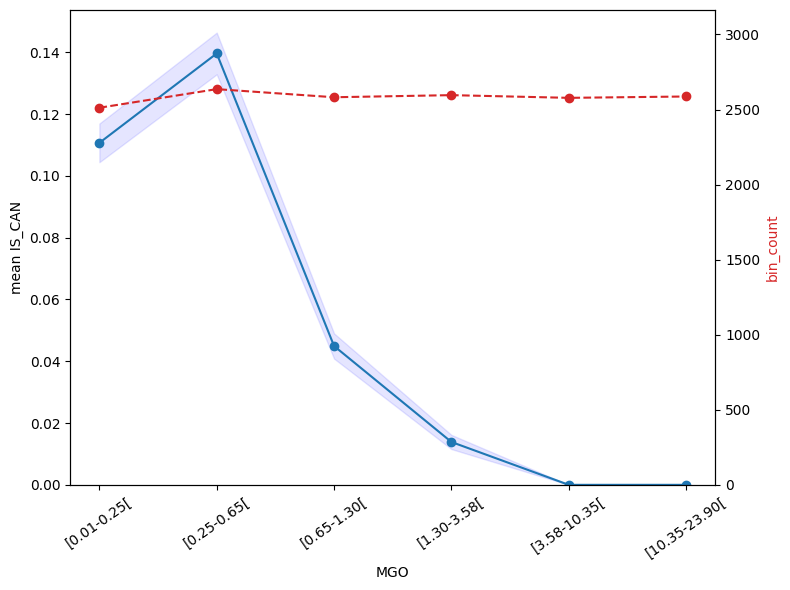

In [50]:
# PDP (Canga)
pdp.pdp(dh, ANALYTES, 'IS_CAN', n=6, writefolder=None, digits=2, figsize=(8,6))

- A frequência média de `Canga` tende a aumentar com a redução dos teores de `CAO`, `SIO2` e `MGO`. Isso já era esperado, pois, durante a ação do intemperismo químico, esses elementos maiores são lixiviados por serem mais móveis.
- A frequência média de `Canga` tende a aumentar com o aumento dos teores de `FE2O3`. Isso era esperado, já que tal rocha é uma concreção rica em Fe.

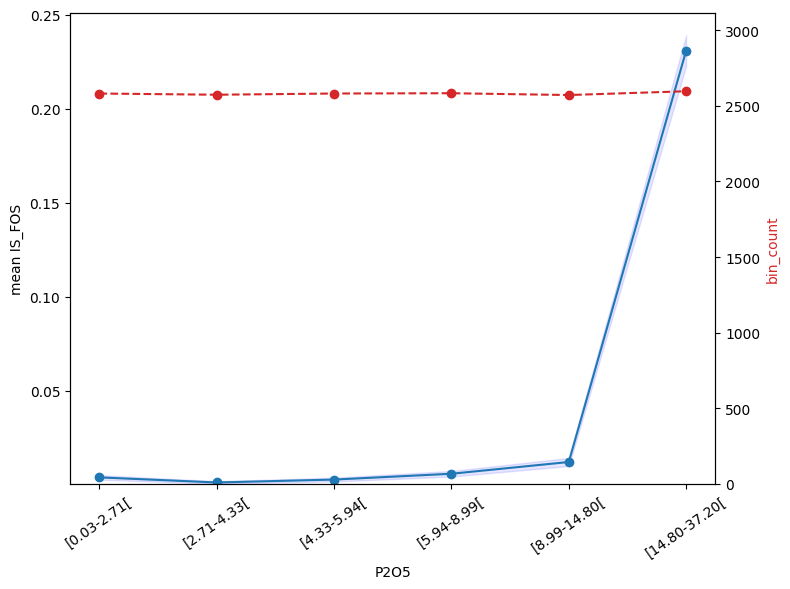

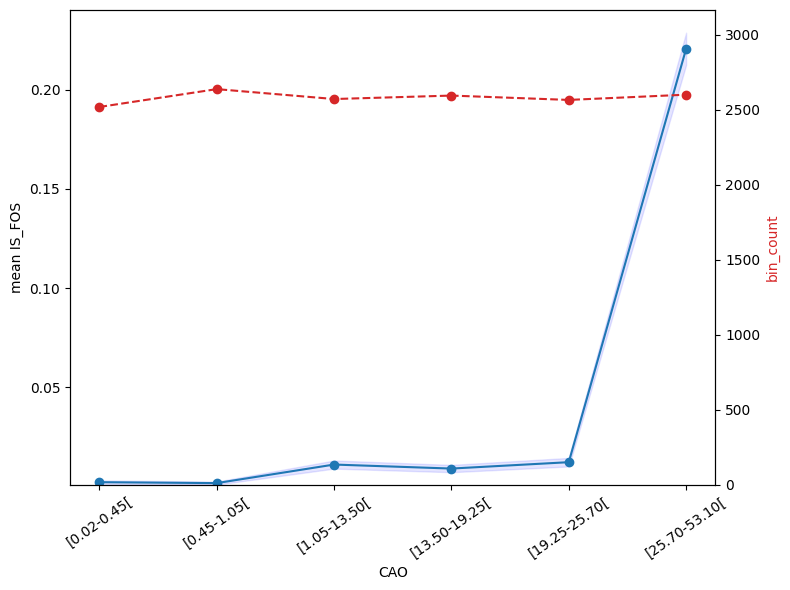

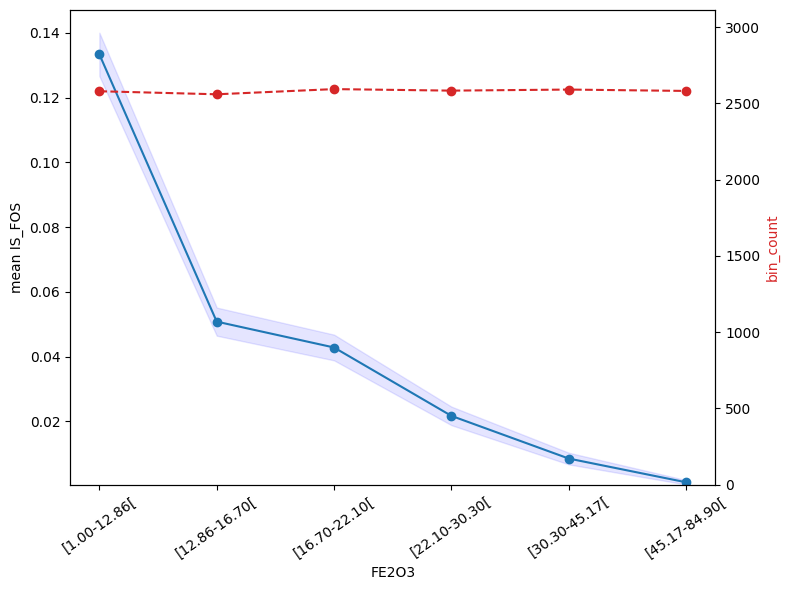

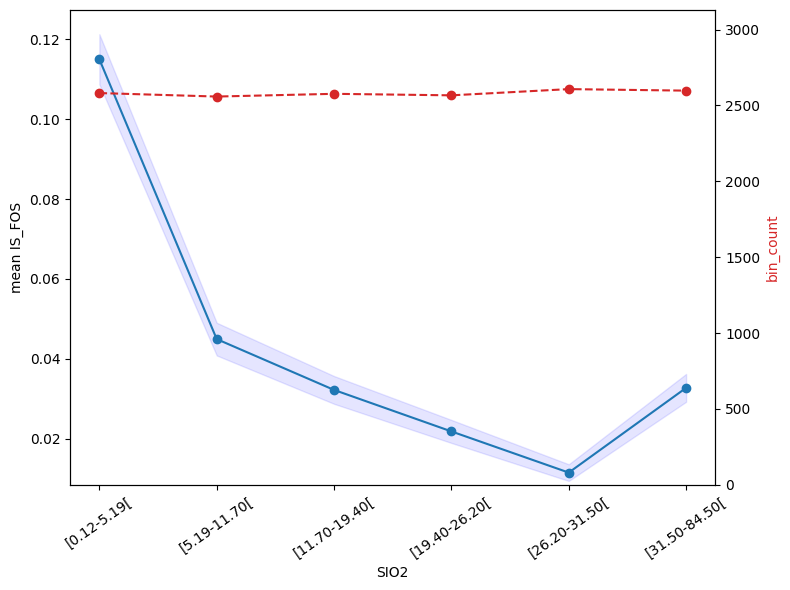

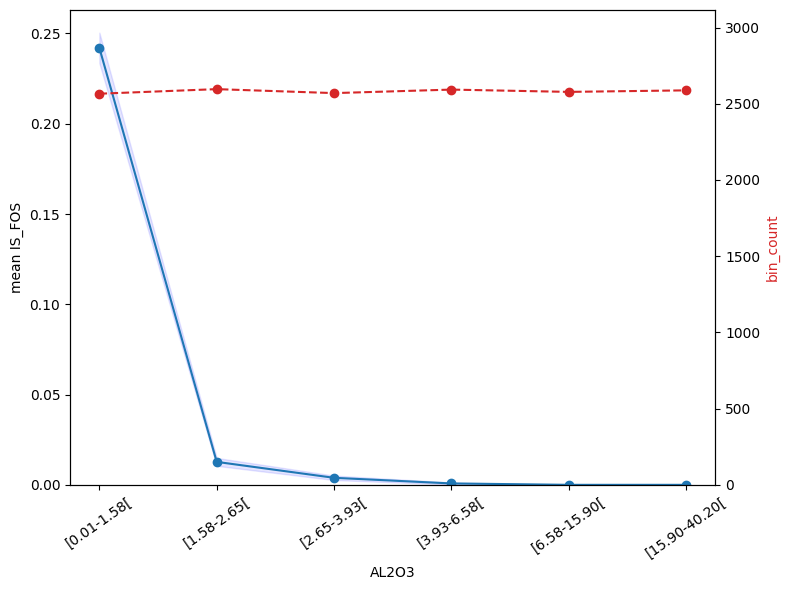

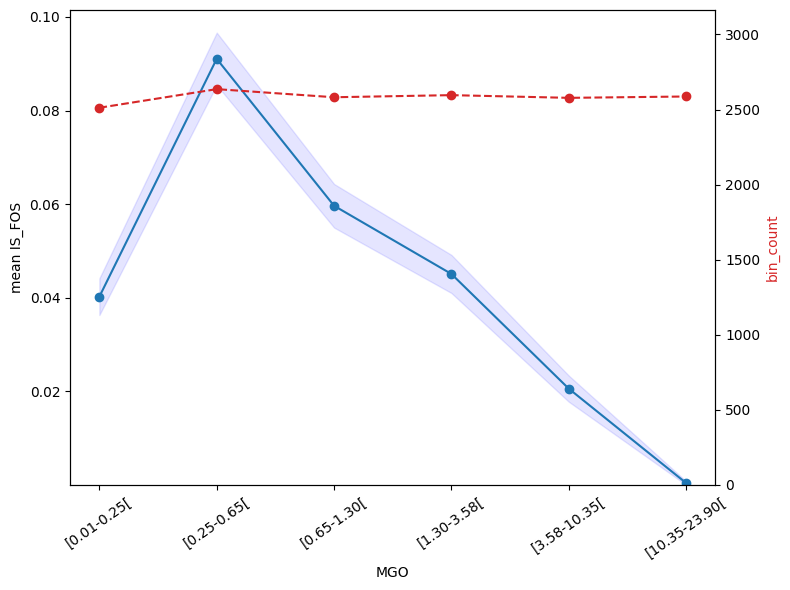

In [51]:
# PDP (Foscrete)
pdp.pdp(dh, ANALYTES, 'IS_FOS', n=6, writefolder=None, digits=2, figsize=(8,6))

- A frequência média de `Foscrete` tende a aumentar com o aumento dos teores de `P2O5`. Isso já era esperado, pois, essa rocha é uma concreção fosfática que acumula `P2O5` durante a ação do intemperismo químico.
- A frequência média de `Foscrete` tende a aumentar com o aumento dos teores de `CAO`. Isso já era esperado, pois, essa rocha é constituída principalmente por apatita, um fosfato de cálcio.
- A frequência média de `Foscrete` tende a aumentar com a redução dos teores de `MGO`. Isso já era esperado, pois, durante a ação do intemperismo químico o Mg é lixiviado.

### Análise de Componentes Principais

A Análise de Componentes Principais (ACP) consiste em um algoritmo que objetiva encontrar projeções similares às instâncias originais, mas que apresentam uma dimensionalidade significativamente menor. A partir da ACP, são calculadas as componentes principais, ou seja, vetores ortogonais entre si no espaço de atributos (i.e. feature space) que definem um novo sistema de coordenadas em que os dados originais serão projetados.

**Nota:** neste trabalho, a ACP será realizada para fins exploratórios e de visualização de dados, mas não para fins de pré-processamento.

In [52]:
# Cálculo das componentes principais
pca = PCA(n_components = len(ANALYTES))
pca.fit(dh[ANALYTES].values)
principal_components = pca.transform(dh[ANALYTES].values)

A figura a seguir mostra um gráfico da variância explicada relativa por cada uma das seis componentes principais.

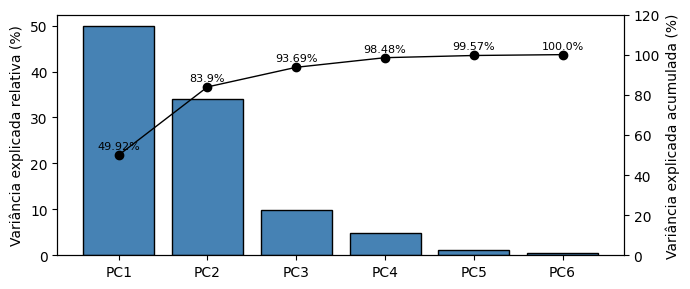

In [53]:
plot.plot_explained_variance_for_pcs(pca)

- As duas primeiras componentes principais (i.e. `PC1` e `PC2`) "explicam" > 80% da variância presente nas seis features iniciais.

A figura abaixo apresenta um scatter plot entre as duas primeiras componentes principais colorido pela variável categórica `LITO`:

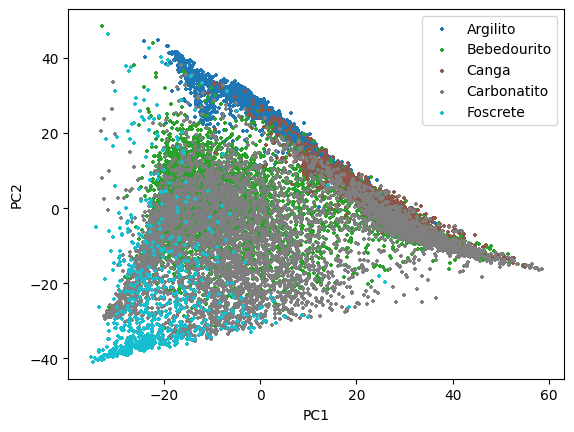

In [54]:
plot.plot_pcs_colored_by_litho(principal_components, dh['LITO'].values)

- De modo geral, as litologias mostram um certo grau de separação entre si, quando plotadas sobre as duas primeiras componentes principais.
- A litologia `Argilito` é mais frequente para valores de `PC2` superiores a 20.
- A litologia `Bebedourito` é mais frequente para valores de `PC2` superiores -20.
- A litologia `Canga` é mais frequente para valores de `PC2` superiores 0.
- A litologia `Carbonatito` ocorre de forma espalhada ao longo do espaço das componentes `PC1` e `PC2`.
- A litologia `Foscrete` é mais frequente para valores de `PC1` inferiores a 0.

## Pré-processamento

As etapas de pré-processamento dos dados são:

1. Codificação binária da variável `LITO` (i.e. _One Hot Encoding_).
2. Estandardização das variáveis.

Neste trabalho, como o objetivo é encontrar possíveis descrições litológicas anômalas, a variável `LITO` é tratada como feature. Caso ela não fosse considerada como feature, o modelo resultante treinado apenas com os analitos poderia ser útil para detectar eventuais erros analíticos, mas não erros associados à descrição litológica dos furos. Como `LITO` é uma variável categórica, ela será codificada em colunas $k$ variáveis _dummy_, sendo $k$ o número de litotipos.

Em seguida, as features contínuas (i.e. analitos) serão estandardizadas. Esta é uma boa prática, já que alguns modelos podem sofrer com viéses associados à magnitude das features.

Definidas as etapas de pré-processamento, o pipeline de pré-processamento pode ser instanciado:

In [55]:
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(), ['LITO']),
        ('continuous', StandardScaler(), ANALYTES)
    ])

## Modelagem dos dados

Neste trabalho, será utilizado o algoritmo não supervisionado baseado no princípio de **isolamento**, denominado **Isolation Forest (ISF)**. Nesse sentido, será criado um pipeline de modelagem definido por duas etapas:

1. Pré-processamento dos dados
2. Instanciamento do modelo

**Nota:** para evitar viéses associados ao desbalanceamento de frequências absolutas entre as litologias, o conjunto de treino foi obtido a partir de uma subamostragem do conjunto de dados. Nesse sentido, 666 intervalos (número de amostras da litologia menos frequente - `Foscrete`) foram aleatoriamente amostrados para cada uma das 5 litologias. Ao final do processo, o conjunto de treino possui 3330 amostras.

In [56]:
# features
X = dh[ANALYTES + ['LITO']]

# conjunto de treino
min_samples = int(dh.LITO.value_counts().min())
X_train = pre.get_uniform_by_litho_train_set(X, 'LITO', nb_samples_by_litho=min_samples)

# predições
dh_pred = dh[PK + COORDS + ['LITO']]
dh_pred['PC1'] = principal_components[:, 0]
dh_pred['PC2'] = principal_components[:, 1]

### Isolation Forest (ISF)

Isolation Forest (ISF) é um algoritmo não supervisionado projetado para detecção de anomalias. Ele funciona isolando observações por meio de uma série de divisões aleatórias no espaço de atributos (i.e. _feature space_). ISF é a versão não supervisionada do algoritmo Random Forest, em que as observações são isoladas ao invés de classificadas em categorias.

A ideia central é que as anomalias (i.e. outliers), por serem diferentes dos dados normais (i.e. inliners), são mais fáceis de isolar. O algoritmo constrói várias árvores de decisão (chamadas de árvores de isolamento), onde cada árvore é criada dividindo os dados aleatoriamente de forma recursiva. Quanto menos divisões forem necessárias para isolar um ponto de dados, mais provável ele ser uma anomalia.

As anomalias geralmente acabam em caminhos mais curtos nas árvores, enquanto as observações normais exigem caminhos mais longos. O modelo agrega essas pontuações de isolamento em todas as árvores para classificar os pontos de dados como normais ou anômalos.

Os principais hiperparâmetros desse algoritmo são:
- `n_estimators:` número de árvores (ou estimadores) a serem usadas na floresta. Um valor maior aumenta a robustez do modelo, mas também o custo computacional.
- `contamination:` proporção de anomalias (i.e. outliers) no conjunto de dados. É usado ao tomar a decisão sobre quais pontos devem ser rotulados como anômalos. Se não for fornecido, o modelo assume que a proporção de outliers é desconhecida. Ajustar esse valor pode impactar a sensibilidade do algoritmo na detecção de anomalias.

**Nota:** neste trabalho, todos os valores de hiperparâmetros foram assumidos como default, com exceção do hiperparâmetro `contamination`, em que se tomou a decisão de que a proporção de anomalias na base de dados é de 5%.

In [57]:
isf = IsolationForest(contamination=0.05,
                      n_estimators=500,
                      n_jobs=-1,
                      random_state=42)

isf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('anomaly_detection', isf)
])

isf_pipeline.fit(X_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(), ['LITO']),
                                                 ('continuous',
                                                  StandardScaler(),
                                                  ['P2O5', 'CAO', 'FE2O3',
                                                   'SIO2', 'AL2O3', 'MGO'])])),
                ('anomaly_detection',
                 IsolationForest(contamination=0.05, n_estimators=500,
                                 n_jobs=-1, random_state=42))])

### Predições

In [58]:
dh_pred['ANOMALY_SCORE'] = isf_pipeline.decision_function(X)
dh_pred['IS_ANOMALY'] = isf_pipeline.predict(X)
dh_pred['IS_ANOMALY'] = dh_pred['IS_ANOMALY'].apply(lambda x: 0 if x != -1 else 1)
dh_pred.head()

,BHID,FROM,TO,X,Y,Z,LITO,PC1,PC2,ANOMALY_SCORE,IS_ANOMALY
0,DH-0001,3.40,5.00,678.2769,1906.266,408.3772,Argilito,24.983979,1.637063,0.011726,0
1,DH-0001,5.00,8.65,678.1301,1906.344,405.7575,Argilito,23.236173,2.358010,0.033518,0
2,DH-0001,8.65,12.00,677.9395,1906.447,402.2642,Bebedourito,22.764923,2.640683,0.050161,0
3,DH-0001,12.00,15.00,677.7742,1906.552,399.0953,Bebedourito,24.580629,2.168093,0.055348,0
4,DH-0001,15.00,18.00,677.6160,1906.664,396.1015,Bebedourito,22.574931,4.138958,0.046921,0


## Avaliação do modelo

Validar modelos não supervisionados é uma tarefa difícil. Três abordagens serão utilizadas:
1. Validação visual do modelo no espaço das componentes principais
2. Validação por _domain knowledge_
3. Validação por injeção de anomalias sintéticas

### Validação visual

A figura abaixo mostra a disposição das observações no espaço das duas primeiras componentes principais. Foi construído um gráfico distinto para cada litologia. As observações foram categorizadas em:
- **Inliners:** observações "normais", que não foram consideradas anomalias pelo modelo.
- **Anomalias:** anomalias identificadas pelo modelo Isolation Forest.

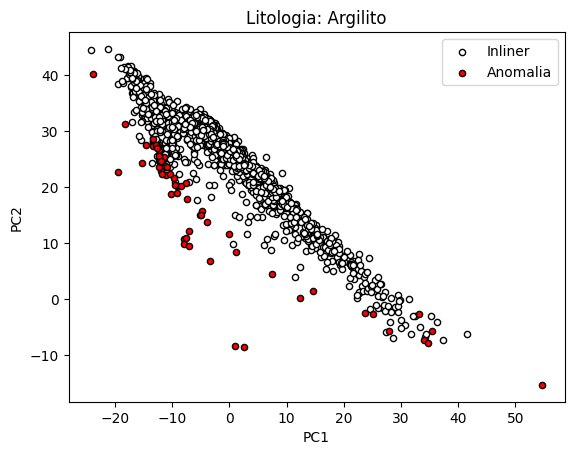

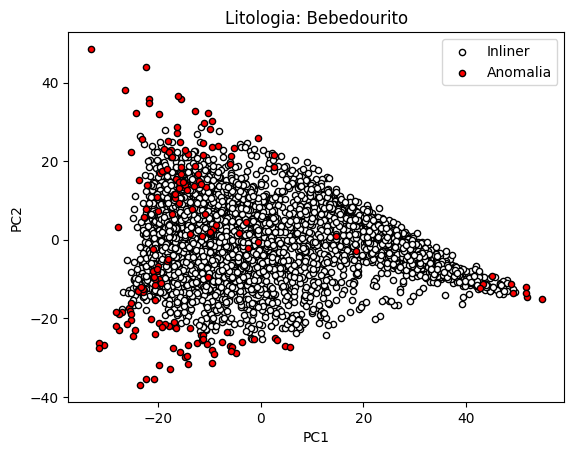

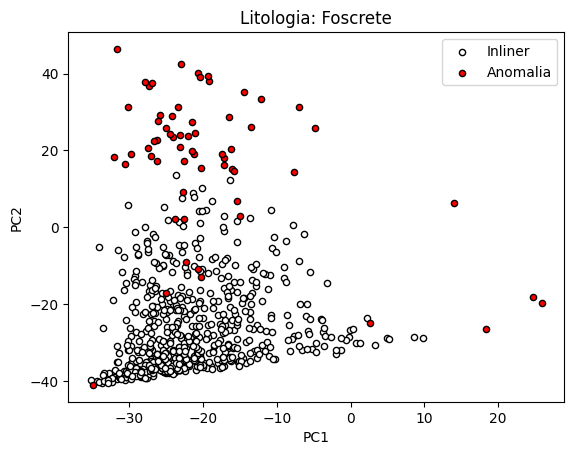

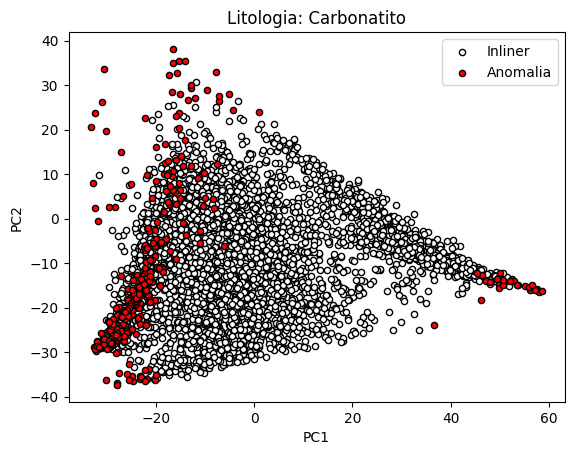

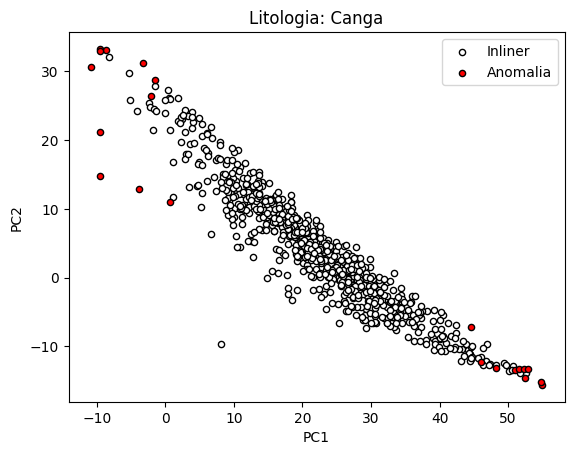

In [59]:
for litho in list(dh_pred.LITO.unique()):
    plot.plot_model_pred_by_litho(dh_pred, litho)

- Nota-se que, de forma geral, as anomalias identificadas se situam em porções com menor densidade amostral no espaço das componentes principais. Isso era justamente o fenômeno esperado.

### Validação por domain knowledge

Nesta sessão, as anomalias identificadas pelos modelos serão rotuladas. Ao todo foram identificados 696 intervalos anômalos (`ANOMALY_SCORE < 0`). Esses intervalos foram ordenados, de forma decrescente, com relação ao `ANOMALY_SCORE`.

In [60]:
dh_anomaly = post.get_anomalies(dh, dh_pred)
print(f"Total de intervalos anômalos: {len(dh_anomaly)}")
dh_anomaly.head()

Total de intervalos anômalos: 696


,BHID,FROM,TO,X,Y,Z,P2O5,CAO,FE2O3,SIO2,AL2O3,MGO,LITO,ANOMALY_SCORE,IS_ANOMALY
10665,DH-0358,107.50,110.00,991.1258,3307.028,257.3912,0.62,7.57,3.20,62.40,2.61,14.40,Carbonatito,-0.082091,1
15394,DH-0541,103.70,107.00,1672.3803,2798.047,300.1345,5.65,8.34,8.80,57.60,5.30,6.13,Foscrete,-0.075710,1
12361,DH-0422,110.05,114.30,2734.2950,3055.259,240.6950,0.44,28.00,1.00,0.37,0.01,21.50,Carbonatito,-0.067428,1
11135,DH-0375,118.60,121.10,1778.5105,3408.560,294.1806,4.36,8.65,12.00,53.30,2.01,9.81,Foscrete,-0.064370,1
12337,DH-0421,101.25,104.35,2827.6740,3056.024,249.5500,2.41,30.90,1.85,0.24,0.01,19.10,Carbonatito,-0.063481,1


- Do ponto de vista geoquímico, as amostras descritas como `Carbonatito` apresentam teores de `MGO` elevados e teores de `P2O5` substancialmente inferiores aos esperados para essa litologia, sugerindo inconsistências.
- De modo semelhante, as amostras classificadas como `Foscrete` apresentam teores atípicos de `SIO2`.

O gráfico abaixo mostra a distribuição de frequências das litologias consideradas anômalas pelo modelo:

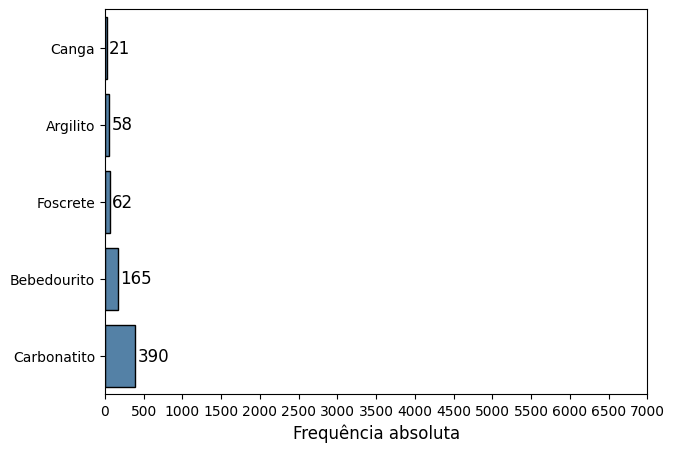

In [61]:
# Frequência absoluta das litologias anômalas
plot.plot_category_frequencies(dh_anomaly, 'LITO')

- A litologia com maior frequência de intervalos anômalos é o `Carbonatito`, seguida pelo `Bebedourito`.

### Validação por injeção de anomalias

Nesta sessão, algumas anomalias artificiais serão introduzidas para avaliar o desempenho do modelo Isolation Forest. Essas anomalias consistem um intervalos artificalmente gerados, onde se sabe que a descrição litológica está incorreta. Esse tipo de validação é comum em tarefas do tipo detecção de anomalias não-supervisionada, em que não existe uma variável resposta (i.e. target).

A seguinte convenção foi adotada:
- `0:` inliner (dado normal)
- `1:` outlier (dado anômalo)

In [62]:
injected_anomalies = io.read_csv('injected_anomalies.csv')
injected_anomalies

,P2O5,CAO,FE2O3,SIO2,AL2O3,MGO,LITO
0,55.3,0.5,2.3,1.2,20.10,15.2,Bebedourito
1,40.5,2.2,1.2,5.6,23.50,18.5,Bebedourito
2,2.2,0.5,1.2,60.1,22.50,11.2,Carbonatito
3,0.5,1.2,2.3,65.2,20.20,9.2,Carbonatito
4,20.0,11.0,55.3,9.0,5.40,6.1,Argilito
5,17.5,13.3,2.5,60.0,3.20,5.9,Argilito
6,20.5,20.1,7.2,45.2,0.10,5.2,Canga
7,25.2,25.1,5.4,38.2,0.05,4.1,Canga
8,7.5,2.1,50.9,1.2,25.20,12.5,Foscrete
9,5.9,0.6,55.6,0.2,21.30,14.2,Foscrete


In [63]:
injected_anomalies['IS_ANOMALY'] = isf_pipeline.predict(injected_anomalies)
injected_anomalies['IS_ANOMALY'] = injected_anomalies['IS_ANOMALY'].apply(lambda x: 0 if x != -1 else 1)
injected_anomalies

,P2O5,CAO,FE2O3,SIO2,AL2O3,MGO,LITO,IS_ANOMALY
0,55.3,0.5,2.3,1.2,20.10,15.2,Bebedourito,1
1,40.5,2.2,1.2,5.6,23.50,18.5,Bebedourito,1
2,2.2,0.5,1.2,60.1,22.50,11.2,Carbonatito,1
3,0.5,1.2,2.3,65.2,20.20,9.2,Carbonatito,1
4,20.0,11.0,55.3,9.0,5.40,6.1,Argilito,1
5,17.5,13.3,2.5,60.0,3.20,5.9,Argilito,1
6,20.5,20.1,7.2,45.2,0.10,5.2,Canga,1
7,25.2,25.1,5.4,38.2,0.05,4.1,Canga,1
8,7.5,2.1,50.9,1.2,25.20,12.5,Foscrete,1
9,5.9,0.6,55.6,0.2,21.30,14.2,Foscrete,1


- Dos 10 intervalos artificiais anômalos avaliados, o modelo ISF rotulou 9 deles como anomalias. Isso corresponde a uma acurácia de 100%.

## Conclusão

- Os resultados obtidos demonstram que o algoritmo Isolation Forest é uma ferramenta eficaz e robusta para a identificação de anomalias em descrições litológicas, mesmo em contextos de alta heterogeneidade geoquímica. O modelo foi capaz de identificar amostras com padrões composicionais incompatíveis com as litologias declaradas, sugerindo possíveis erros de classificação durante a descrição macroscópica. Além disso, apresentou desempenho perfeito na detecção de anomalias sintéticas, evidenciando sua alta sensibilidade a desvios estatísticos nas 
variáveis químicas.

- O fluxo metodológico proposto apresenta baixo custo computacional, elevada reprodutibilidade e é facilmente escalável para aplicações em sistemas automatizados de controle de qualidade de dados geológicos. Sua adoção pode representar um avanço significativo nos processos de verificação de bases litológicas, contribuindo para a melhoria da consistência dos dados utilizados na modelagem geológica e na estimativa de recursos minerais.

- Recomenda-se sua aplicação sistemática em campanhas de revisão de dados históricos, especialmente em depósitos cuja definição litológica impacta diretamente os domínios de interpolação e a confiabilidade dos modelos geometalúrgicos.
